In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_series(time, series, start=0, end=None):
  plt.plot(time[start:end], series[start:end], "-")
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

In [3]:
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv -O /tmp/sunspots.csv

--2020-08-17 10:08:18--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.128, 173.194.79.128, 108.177.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2020-08-17 10:08:18 (105 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



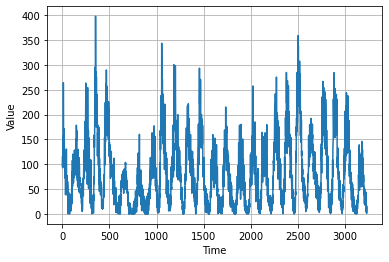

In [4]:
import csv
time = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time)
plot_series(time,series)

In [5]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size+1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[1:]))
  ds = ds.batch(batch_size).prefetch(1)
  return ds

In [7]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)

In [10]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5, strides=1, padding="causal", activation='relu', input_shape=[None,1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation='relu'),
  tf.keras.layers.Dense(30, activation='relu'),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x*400)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(train_set, epochs=400)

Epoch 1/400
30/30 [==============================] - 3s 111ms/step - loss: 32.0610 - mae: 32.5564
Epoch 2/400
30/30 [==============================] - 3s 111ms/step - loss: 22.4615 - mae: 22.9550
Epoch 3/400
30/30 [==============================] - 3s 109ms/step - loss: 20.1814 - mae: 20.6745
Epoch 4/400
30/30 [==============================] - 3s 110ms/step - loss: 19.7084 - mae: 20.2011
Epoch 5/400
30/30 [==============================] - 3s 110ms/step - loss: 19.7143 - mae: 20.2070
Epoch 6/400
30/30 [==============================] - 3s 110ms/step - loss: 19.0561 - mae: 19.5484
Epoch 7/400
30/30 [==============================] - 3s 108ms/step - loss: 18.5357 - mae: 19.0278
Epoch 8/400
30/30 [==============================] - 3s 111ms/step - loss: 18.6932 - mae: 19.1853
Epoch 9/400
30/30 [==============================] - 3s 109ms/step - loss: 17.9920 - mae: 18.4837
Epoch 10/400
30/30 [==============================] - 3s 110ms/step - loss: 17.9377 - mae: 18.4295
Epoch 11/400
30/30 

15.931247


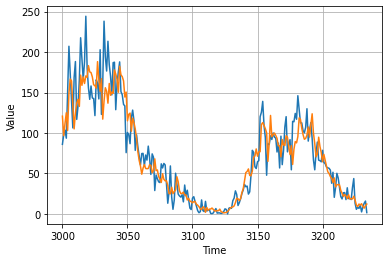

In [11]:
forecast = model_forecast(model, series[..., np.newaxis], window_size)
forecast = forecast[split_time - window_size:-1, -1, 0]
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)
print(tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy())

<Figure size 432x288 with 0 Axes>

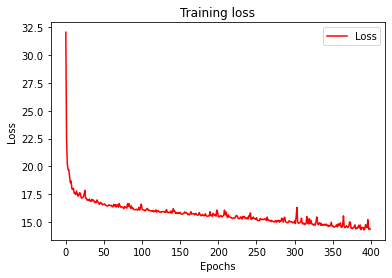

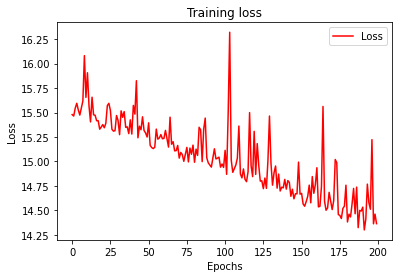

<Figure size 432x288 with 0 Axes>

In [12]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

loss=history.history['loss']
epochs=range(len(loss))

plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

zoomed_loss = loss[200:]
zoomed_epochs = range(len(zoomed_loss))

plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()